# <p style="font-size: 1.0em; color:#DD3D1B; ">__Rossmann Sales Prediction__</p>

# 1. Business Understanding


## 1.1. Determine Business Objectives



### → Background

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with **predicting their daily sales for up to six weeks in advance**. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### → Business Objectives

1. The company wants to use the predictions to better allocate resources for future growth and manage its cash flow.
2.  Set goals for sales teams in each drugstore based on model’s predictions.

### → Business Success Criteria

The success of this project is based on the reliability of the predictions provided by the model. The business team defined a threshold of 10% to consider the model useful for business objectives.


## 1.3. Determine Data Mining Goals


### → Data Mining Goals

- To find a Machine Learning Model that predicts daily sales for up to six weeks in advance for each drugstore.

### → Data Mining Success Criteria

Build KPI to fulfill the business objectives and criteria.

- MAE ( Mean Absolute Error )
- MAPE (Mean Absolute Percentage Error )
- RMSE ( Root Mean Squared Error )
- RMSPE ( Root Mean Square Percentage Error)

## 1.4. Produce Project Plan

→ Project Plan

→ Initial Assessment of tools and techniques

# Appendix

## I. Import Libraries

In [304]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import json

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## II. Helper Functions

In [305]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


#==================================================#
#               ERROR FUNCTION                     #
#==================================================#
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


#==================================================#
#               CROSS VALIDATION                   #
#==================================================#
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## III. Load Dataset

In [306]:
# Load dataset
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw ,df_store_raw ,how='left', on='Store')

# 2. Data Undestanding 

## 2.1. Collect Initial Data

The data was imported from kaggle.com competition.
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

## 2.2. Describe Data

- The dataset provides historical sales data for 1,115 Rossmann stores. 
- Some stores in the dataset were temporarily closed for refurbishment.

In [112]:
df2 = df_raw.copy()

### 2.2.1. Rename the columns (just for convenience)

In [113]:
cols_old = df2.columns

snakecase = lambda x: inflection.underscore(x) #função lambda para alterar colunas
cols_new = list( map( snakecase, cols_old))

# RENAME
df2.columns = cols_new

### 2.2.2 Data Dimensions

In [114]:
print( 'Number of Records  : {}'.format( df2.shape[0] ) )
print( 'Number of Features : {}'.format( df2.shape[1] ) )

Number of Records  : 1017209
Number of Features : 18


### 2.2.3. Data Type

In [115]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

## 2.4. Verify Data Quality

### 2.4.1. Datatype changes required

In [116]:
# Feature date changed to datetime type
df2.date = pd.to_datetime(df2.date)
print('Date feature set as {}'.format(df2['date'].dtypes) )

Date feature set as datetime64[ns]


### 2.4.2. Check for existing missing values in data

In [117]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 2.4.3. Fill out the missing values

#### Feature descriptions aer given by business team


- __competition_distance:__ distance in meters to the nearest competitor store.
- __competition_open_since(month/year):__ gives the approcimate year and month of the time the nearest competitor was opened.
- __promo2_since(week/year):__ describes the year and calendar week when the store started participating in Promo2.
- __promo_interval:__ describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

### I. competition_distance

<a style="font-size: 1.0em; color:#DD3D1B; ">__Assumption:__</a>
- The drugstores with missing value in _competition_distance_ field mean that there is no competitor reasonably  near.
- For those cases, let’s assume a distance two times the max value reported in data.

In [118]:
print('Competition Distance')
print( 'Min   values for : {} '.format( df2['competition_distance'].min() ) )
print( 'Mean  values for : {} '.format( round( df2['competition_distance'].mean(), 2 ) ) )
print( 'Man   values for : {} '.format( df2['competition_distance'].max() ) )
print( 'Std   values for : {} '.format( round( df2['competition_distance'].std(), 2 ) ) )

filler_competition_distance = 2 * df2['competition_distance'].max()
df2.competition_distance = df2.competition_distance.fillna(filler_competition_distance)

Competition Distance
Min   values for : 20.0 
Mean  values for : 5430.09 
Man   values for : 75860.0 
Std   values for : 7715.32 


### II. competition_open_since

<a style="font-size: 1.0em; color:#DD3D1B; ">__Assumption:__</a>
- The drugstore with missing values in _open_since_ field means that there is no new competitor or the competitor was there before the store opens.
- For those cases, let’s assume a date equal to the last sale; assuming that the new value is so recent that no correlation can be observed yet.

In [119]:
# month
df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1)

# year
df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'] ) 
                                                else x['competition_open_since_year'], axis=1)

### III. promo2_since

<a style="font-size: 1.0em; color:#DD3D1B; ">__Assumption:__</a>
- The drugstore with missing values in _promo2_since_ field means that it is no participating in Promo2.

In [120]:
a = df2[df2['promo2']==0]['promo2'].count()
b = df2[df2['promo2']==0]['promo2_since_week'].isna().sum()
c = df2[df2['promo2']==0]['promo2_since_year'].isna().sum()

print('Comparing the field : ', a, b, c)

Comparing the field :  508031 508031 508031


- For those cases, let's assume a date equal to last sale, assuming that the store just joined the promotion, so no correlation can be observed yet.

In [121]:
# year
df2['promo2_since_year'] = df2.apply(lambda x: x['date'].year 
                                                if math.isnan(x['promo2_since_year'] ) 
                                                else x['promo2_since_year'], axis=1)

# week
df2['promo2_since_week'] = df2.apply(lambda x: x['date'].week 
                                                if math.isnan(x['promo2_since_week'] ) 
                                                else x['promo2_since_week'], axis=1)

### III. promo_interval

<a style="font-size: 1.0em; color:#DD3D1B; ">__Assumption:__</a>
- Let's use the _df2.date.month_ as reference to calculate the promo_interval

In [122]:
#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['promo_interval'].fillna(0, inplace=True )

df2['month_map'] = df2['date'].dt.month.map( month_map )

df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


### Doublecheck type and missing values

In [123]:
# competiton
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )
    
# promo2
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 2.5. Descriptive Statistics

In [124]:
# Split features into categorical and numerical.
num_attributes = df2.select_dtypes( include=['int','float'] )
cat_attributes = df2.select_dtypes( exclude=['int','float','datetime64[ns]'])

#### I. Numerical Attributes

In [125]:
m = num_attributes.describe().T

# dispersion statistics
d1 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ), columns=['skew'] )
d2 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ), columns=['kurtosis'] )

dm = pd.concat( [d1,d2], axis=1 )
dm = pd.concat( [m ,dm], axis=1 )

dm

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0,-0.000955,-1.200524
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0,0.001593,-1.246873
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0,0.641460,1.778375
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0,1.598650,7.091773
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0,-1.758045,1.090723
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0,1.677842,0.815154
competition_distance,1017209.0,5810.044888,10715.012901,20.0,710.0,2330.0,6910.0,151720.0,7.593832,90.447876
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0,-7.235657,124.071304


#### II. Categorical Attributes

In [126]:
cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [127]:
holiday_map = {'0':'0', 'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas'}
df2.state_holiday = df2.state_holiday.map(holiday_map)

df2['state_holiday'].unique()

array(['0', 'public_holiday', 'easter_holiday', 'christmas'], dtype=object)

__BOXPLOT:__

<AxesSubplot: xlabel='assortment', ylabel='sales'>

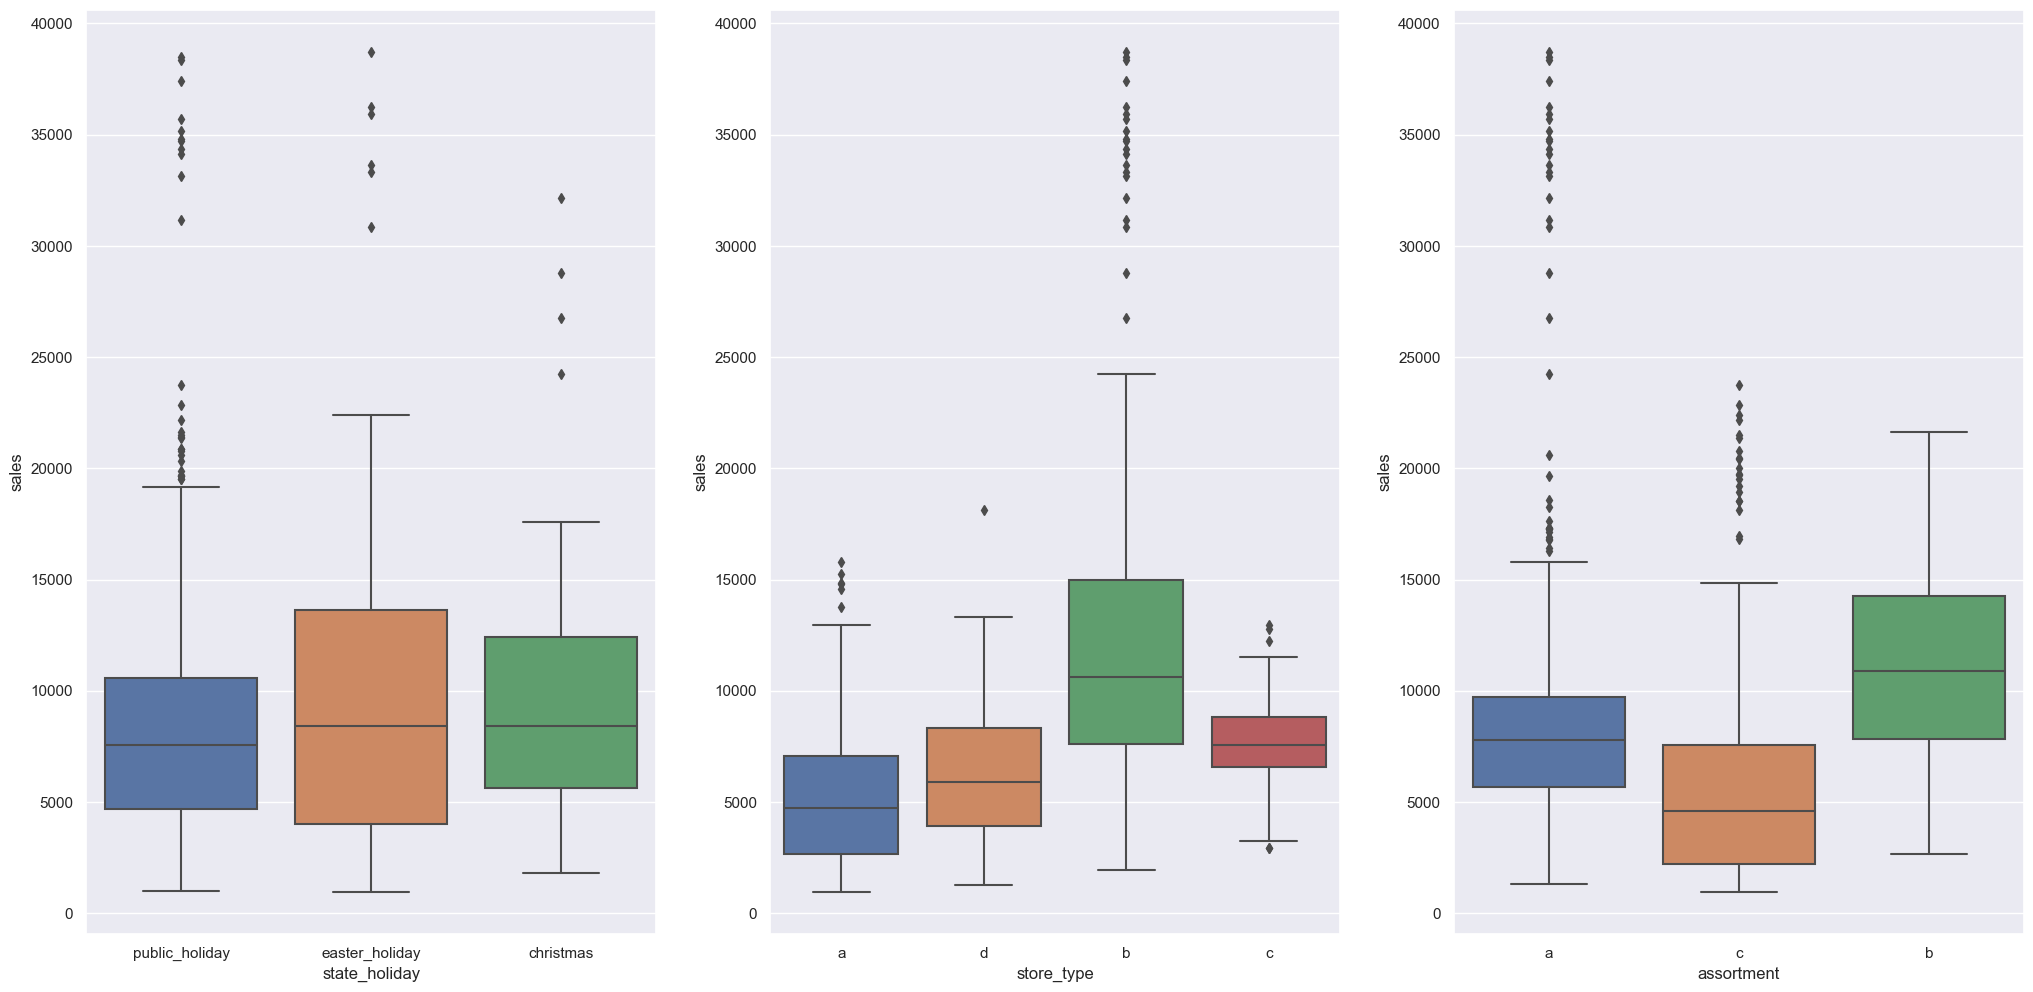

In [128]:
plt.subplot(1,3,1)
# removing holiday equal “0”
box_holiday = df2[ (df2['state_holiday'] != '0' ) & (df2['sales'] > 0  )]
sns.boxplot( x='state_holiday', y='sales', data=box_holiday)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=box_holiday)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=box_holiday)


# 3. Data Preparation

In [129]:
df3 = df2.copy()

## 3.1. Feature Engineering

In [130]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo_since'] = df3['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

## 3.2. Select Data

### 3.2.1. Selection of rows

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [ ]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,0,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.2.2. Selection of Columns

In [ ]:
df3 = df3.drop( ['customers','open','promo_interval','month_map'], axis = 1 )

## 3.3. Exploratory Analisys

### 3.3.1. Univariate Analysis

#### I. Response Vaiable

<AxesSubplot: xlabel='sales'>

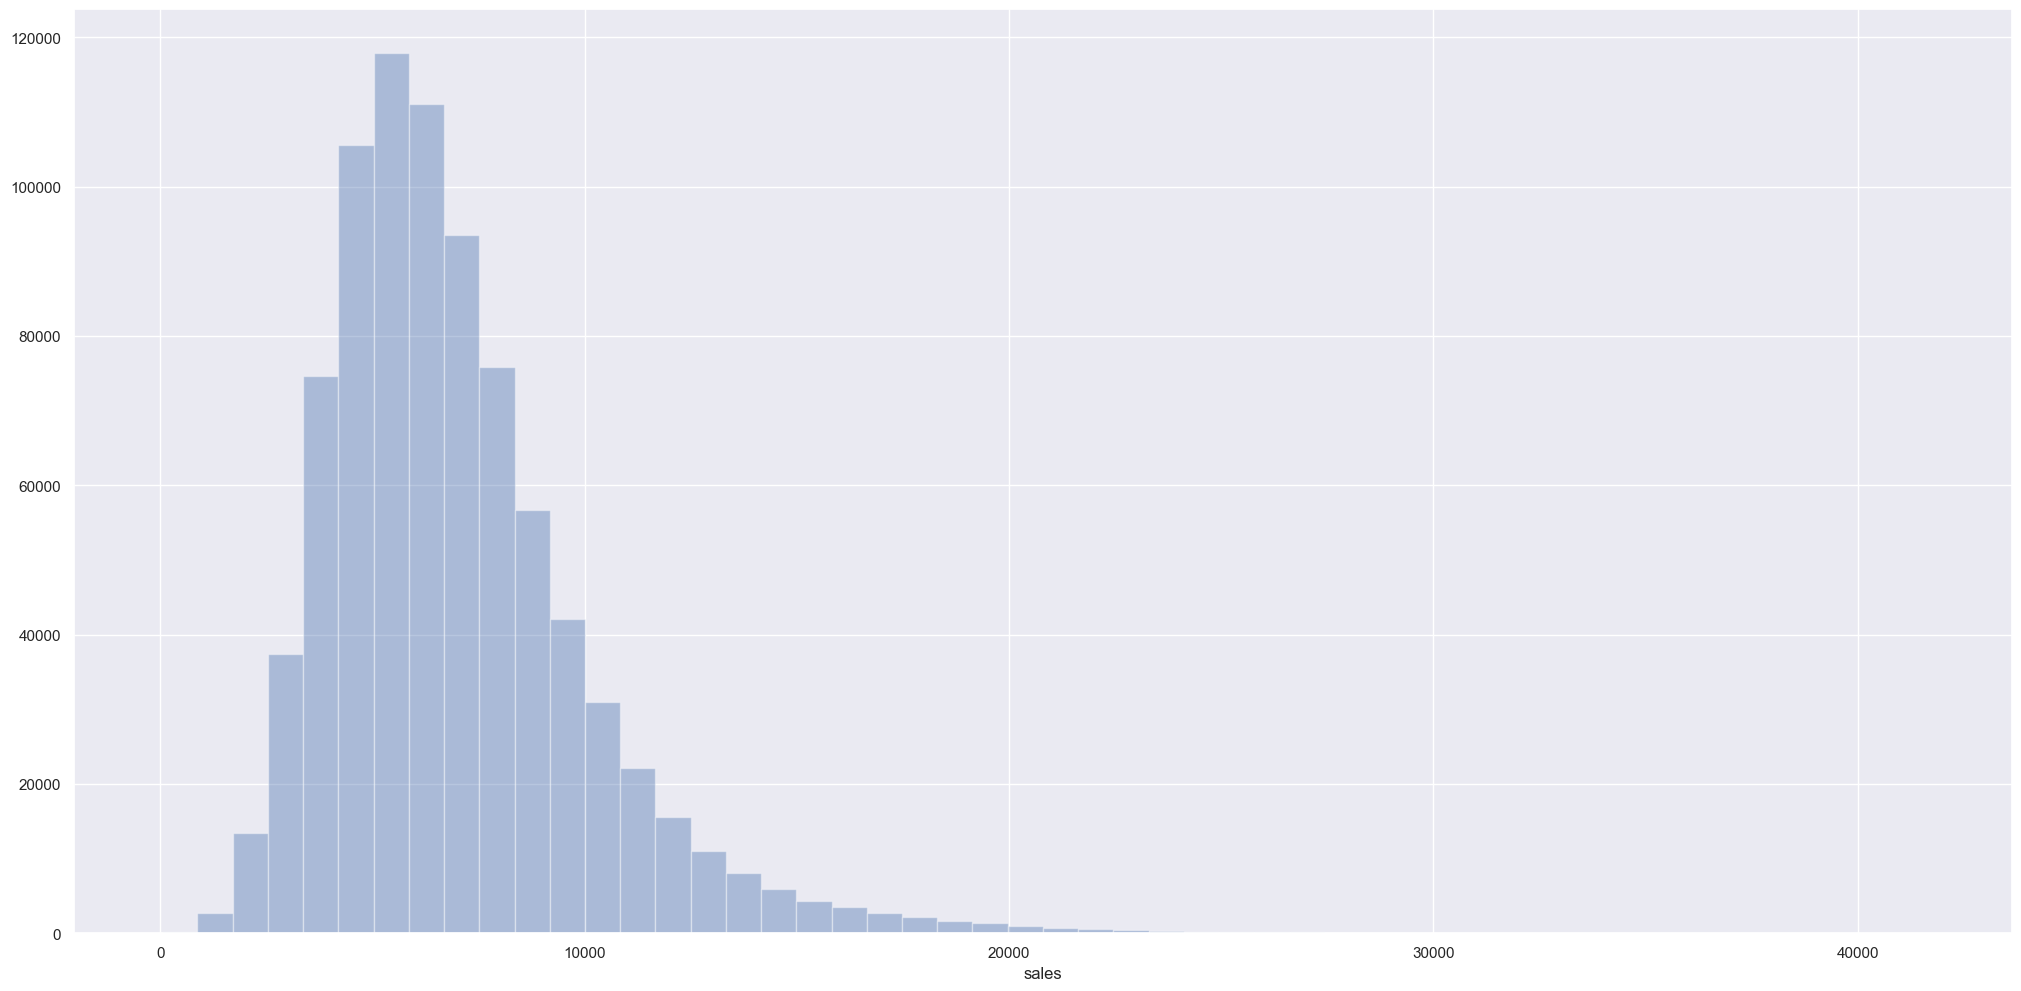

In [32]:
sns.distplot( df3['sales'], kde=False )

#### II. Nomerical Variable 

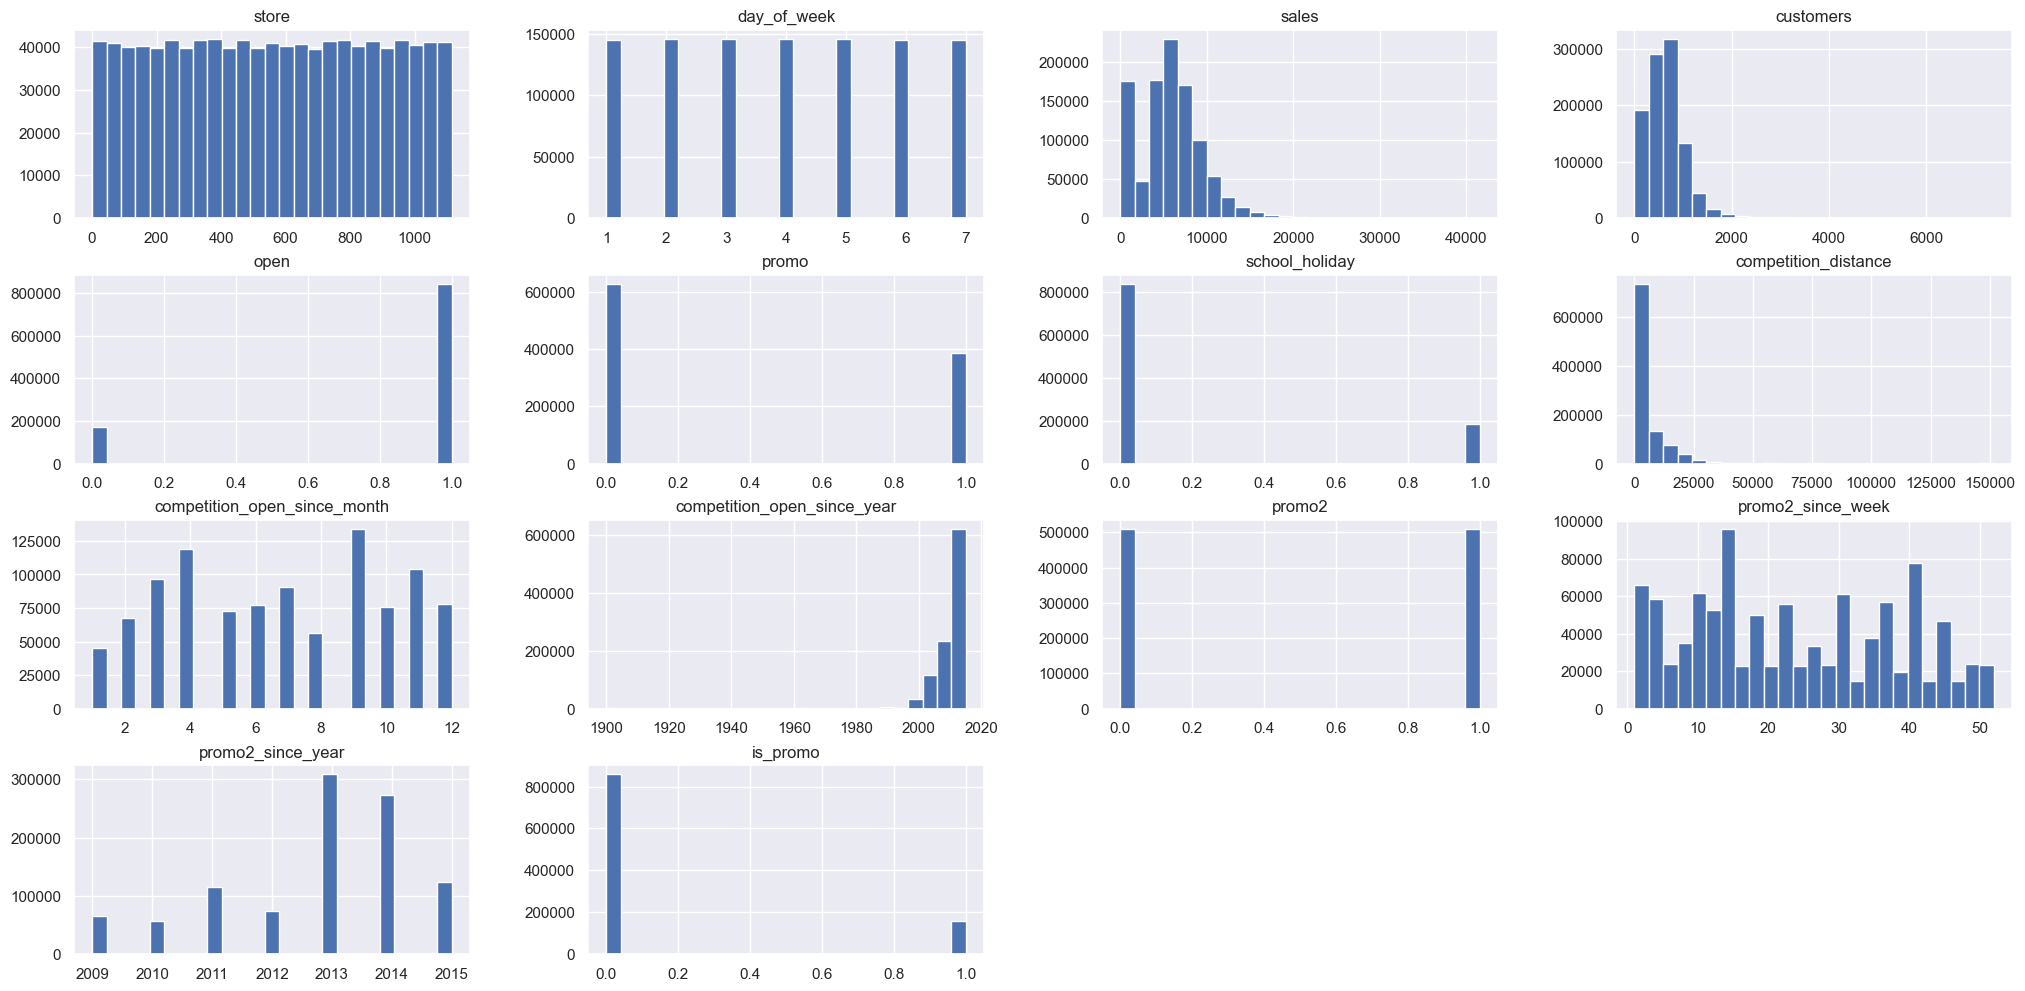

In [33]:
num_attributes.hist( bins=25 );

#### III. Categorical Variable

In [40]:
df3['state_holiday'].unique()
a['state_holiday'].unique()

array(['public_holiday', 'easter_holiday', 'christmas'], dtype=object)

KeyError: 0

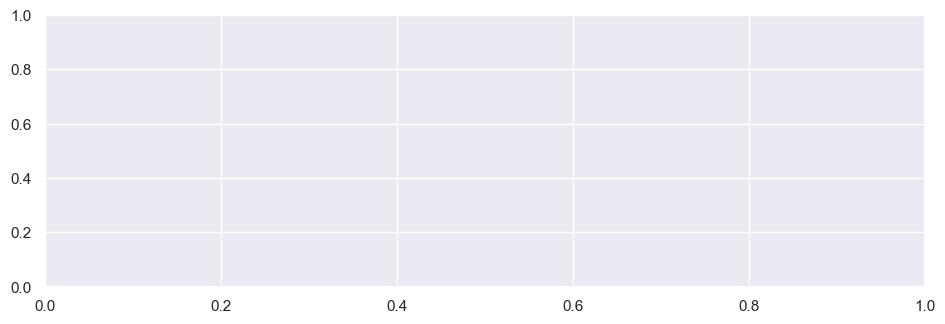

In [42]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df3[df3['state_holiday'] != '0']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( a[a['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( a[a['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( a[a['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( a['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( a[a['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( a[a['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( a[a['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( a[a['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( a['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( a[a['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( a[a['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( a[a['assortment'] == 'extra']['sales'], label='extra', shade=True )

### 3.3.2. Bivariate Analysis

### 4.3.3. Multivariable Analysis

#### I. Numerical Attibute

<AxesSubplot: >

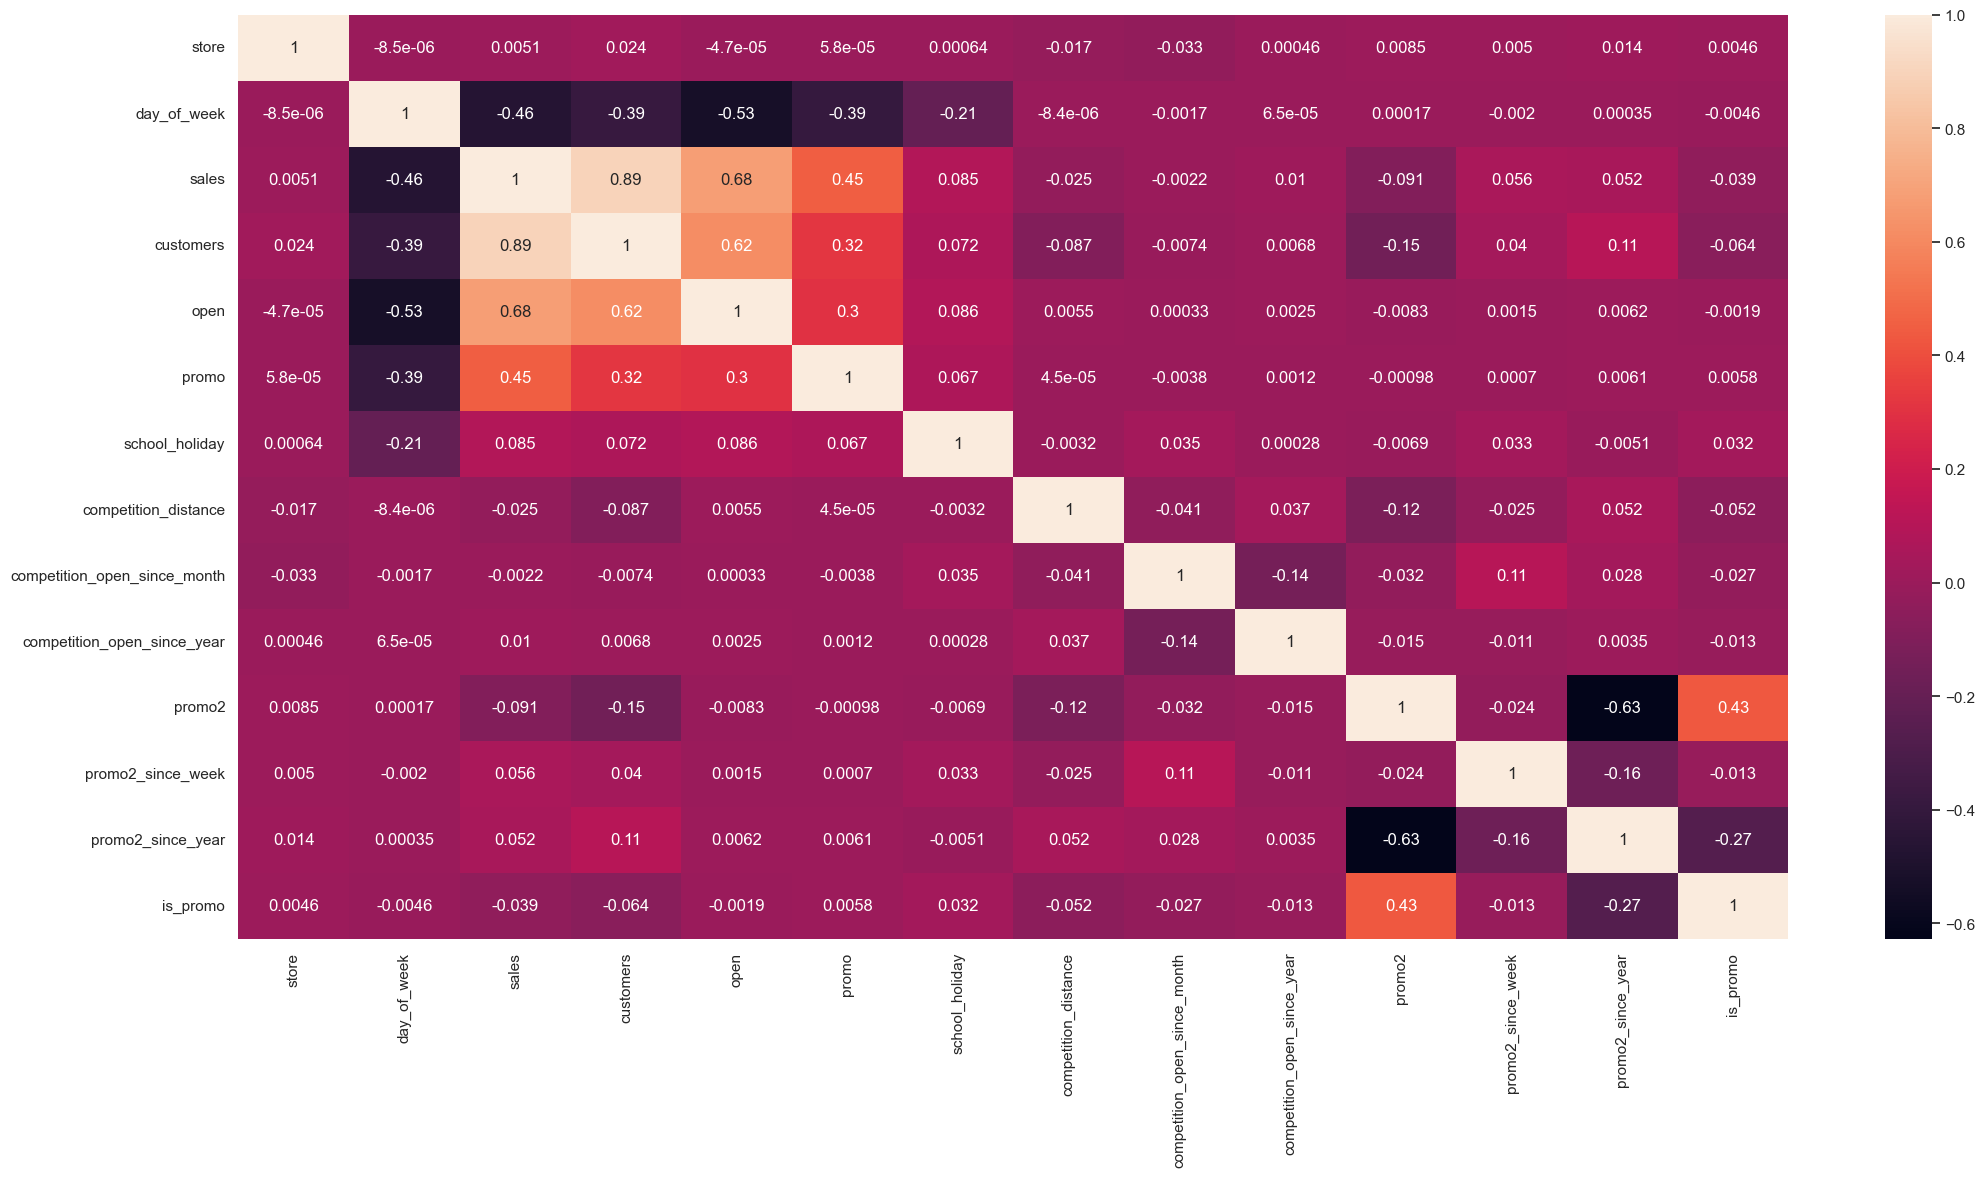

In [43]:
correlation = num_attributes.corr( method= 'pearson' )
sns.heatmap( correlation, annot=True )

#### II. Categorical Attributes

<AxesSubplot: >

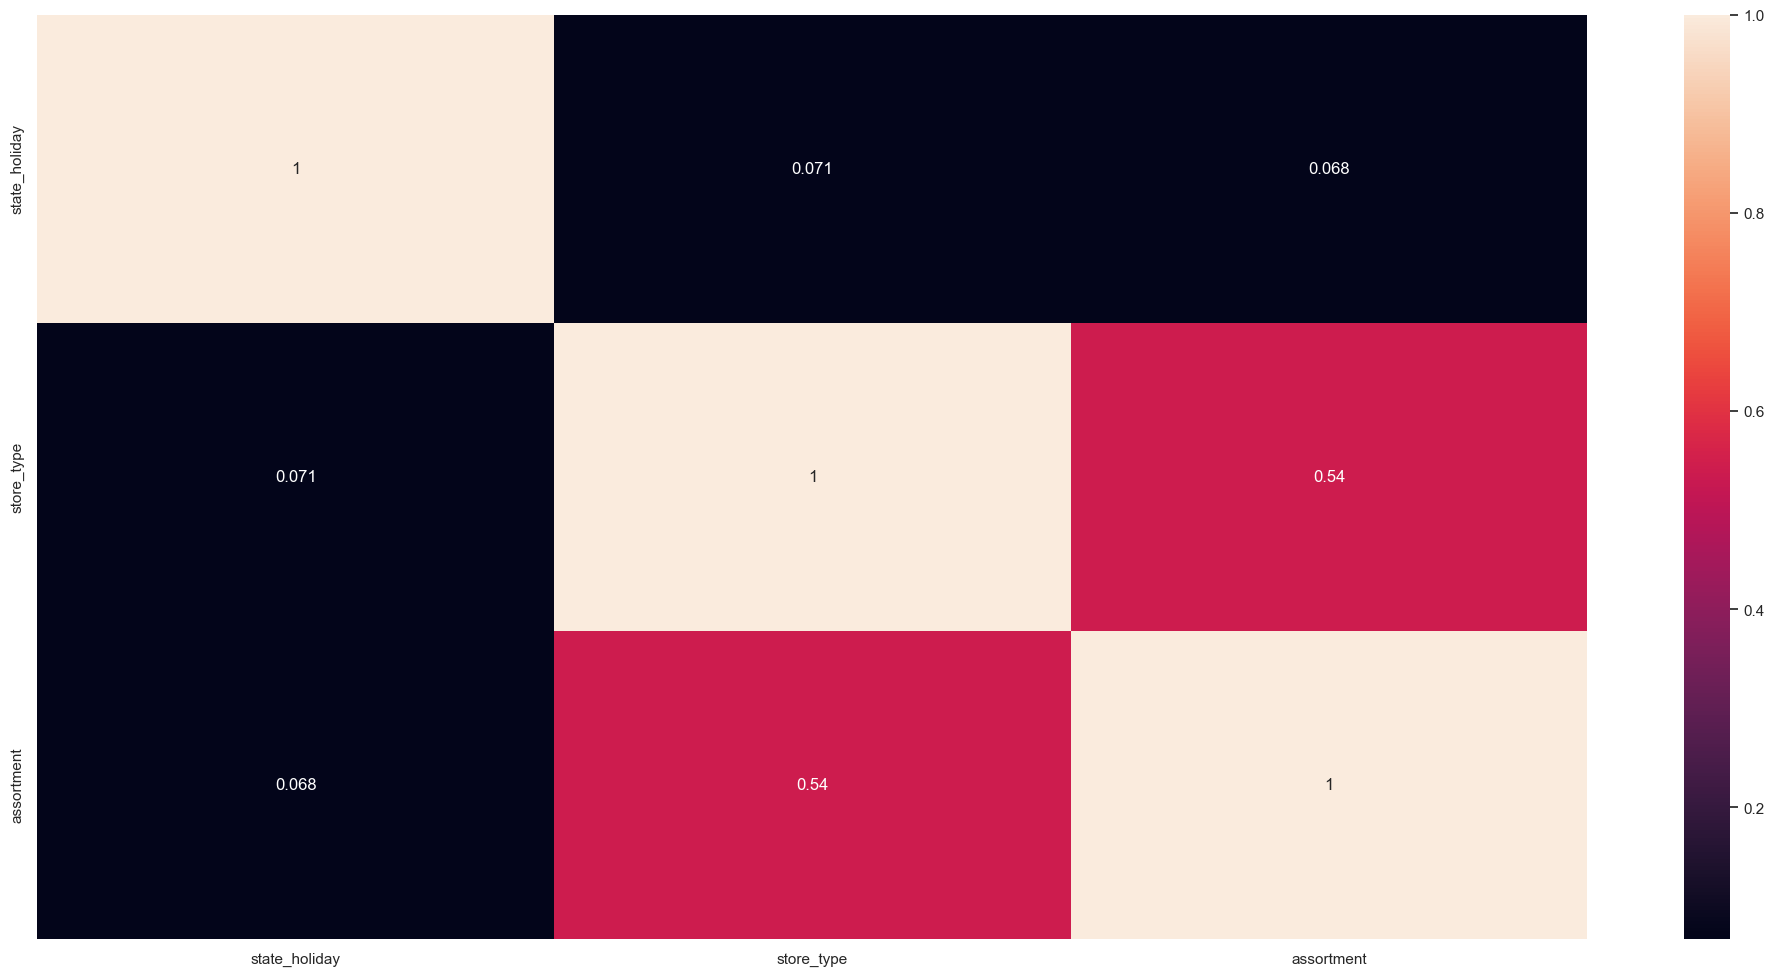

In [44]:
# only categorical data
a = df3.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 4. Format Data

In [ ]:
df4 = df3.copy()

## 4.1. Rescaling

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df4['competition_distance'] = rs.fit_transform( df4[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df4['competition_time_month'] = rs.fit_transform( df4[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df4['promo_time_week'] = mms.fit_transform( df4[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df4['year'] = mms.fit_transform( df4[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 4.2. Transfomations

### 4.2.1. Enconding

In [ ]:
# state_holiday - One Hot Encoding
df4 = pd.get_dummies( df4, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df4['store_type'] = le.fit_transform( df4['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df4['assortment'] = df4['assortment'].map( assortment_dict )

### 4.2.2. Response Variable

In [ ]:
df4['sales'] = np.log1p( df4['sales'] )

### 4.2.3. Nature Transformation

In [ ]:
# day of week
df4['day_of_week_sin'] = df4['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df4['day_of_week_cos'] = df4['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df4['month_sin'] = df4['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df4['month_cos'] = df4['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df4['day_sin'] = df4['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df4['day_cos'] = df4['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df4['week_of_year_sin'] = df4['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df4['week_of_year_cos'] = df4['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 5. Feature Selection

In [ ]:
df5 = df4.copy()

In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df5 = df5.drop( cols_drop, axis=1 )

## 5.1. Split Data

In [ ]:
# training dataset
X_train = df5[df5['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df5[df5['date'] >= '2015-06-19']
y_test = X_test['sales']

## 5.2. Boruta Algorithm

In [53]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 5.2.1. Beat Feature Selected

In [54]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

### 5.2.3. Columns Selected list

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 5. Modelling

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 5.1 Baseline Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 5.2. Linear Regression Model

In [ ]:
# model
linear = LinearRegression().fit( x_train, y_train )

# prediction
linear_pred = linear.predict( x_test )

# preformance
linear_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( linear_pred) )
linear_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.367109,0.292879,2670.993696


### 5.2.1. Linear Regression Model - Cross Validation

In [ ]:
linear_result_cv = cross_validation( x_training, 5, 'Linear Regression', linear, verbose=False )
linear_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65


## 5.3. Linear Regression Regularized - Lasso

In [60]:
# model
lasso = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
lasso_pred = lasso.predict( x_test)

# performance
lasso_result = ml_error( 'Linear Regression Regularized', np.expm1( y_test), np.expm1( lasso_pred ) )
lasso_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1892.318508,0.289171,2744.364677


### 5.3.1. Lasso - Cross Validation

In [61]:
lasso_result_cv = cross_validation( x_training, 5, 'Lasso', lasso, verbose=False )
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.39 +/- 341.56,0.29 +/- 0.01,3057.09 +/- 504.39


## 5.4. Random Forest Regressor

In [62]:
# model
random_forest = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=123 ).fit( x_train, y_train)

# prediction
random_forest_pred = random_forest.predict( x_test )

# performance
random_forest_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( random_forest_pred ) )

In [63]:
random_forest_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.874262,0.100103,1013.101499


### 5.4.1. Random Forest Regressor - Cross Validation

In [50]:
random_forest_cv = cross_validation( x_training, 5, 'Random Forest Regressor', random_forest, verbose=True )
random_forest_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,838.68 +/- 220.47,0.12 +/- 0.02,1256.38 +/- 320.21


## 5.5. XGBoost Regressor

In [64]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
xgb_pred = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( xgb_pred ) )
xgb_result

[09:48:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 5.5.1. XGBoost Regressor - Cross Validation

In [52]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5
[09:44:20] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[09:47:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 3
[

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 5.6. Assess Model

### 5.6.1. Single Performance

In [53]:
modelling_result = pd.concat( [baseline_result, linear_result, lasso_result, random_forest_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.874262,0.100103,1013.101499
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1868.367109,0.292879,2670.993696
0,Linear Regression Regularized,1892.318508,0.289171,2744.364677
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### 5.6.2. Performance by Cross Validation 

In [54]:
modelling_result_cv = pd.concat( [linear_result_cv, lasso_result_cv, random_forest_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65
0,Lasso,2116.39 +/- 341.56,0.29 +/- 0.01,3057.09 +/- 504.39
0,Random Forest Regressor,838.68 +/- 220.47,0.12 +/- 0.02,1256.38 +/- 320.21
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 5.7. Hyperparameter Fine Tune

### 5.7.1. Random Search

In [55]:
# param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

# MAX_EVAL = 5

In [56]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
       
# final_result

## 5.8. Final Model

In [65]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [66]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[09:52:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




KeyboardInterrupt: 

In [ ]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.019542777327281928

# 6.0. Deploy Model to Production

In [69]:
# Save Trained Model
# pickle.dump( model_xgb_tuned, open( '/Users/puppim/Documents/GitHub/Data-Science-Portifolio/DS_em_producao/model/model_rossmann.pkl' , 'wb') )

## 6.1. Rossmann Class

In [70]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann (object):
    def __init__(self):
        self.home_path='/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Rossmann_Prediction/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning ( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        # 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
            
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1



    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        ## 3.1. Filtragem das Linhas
        df2 = df2[(df2['open'] != 0)]
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation (self, df5):

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
       

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # Select columns
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        #predicition
        pred = model.predict( test_data)

        # join pred into the original data
        original_data['predicition'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso')

    

## 6.2. API Handler.py

In [73]:
import pandas as pd
import pickle
from flask            import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Rossmann_Prediction/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] ) #endpoint
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # instantiate Rossmann Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)

        return df_response

    else:
        return Response( '{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' )

[10:22:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[10:22:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[10:22:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:438: 
  If you are loading a serialized mod

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.7:5000
Press CTRL+C to quit


## 6.3. API Tester

Simular ambiente de produção

In [307]:
df10 = pd.read_csv('/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Rossmann_Prediction/data/test.csv')
df_store_raw = pd.read_csv('/Users/puppim/Documents/GitHub/Data-Science-Portifolio/Rossmann_Prediction/data/store.csv')

In [308]:
store = 23

In [309]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'] == 22 ]
df_test = df_test[df_test['Store'].isin( [store] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [310]:
# convert DataFrame to json
data = json.dumps( df_test.to_dict( orient='records') )

In [313]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmannapp.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [314]:
d0 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [315]:
d2 = d0[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 23 will sell R$227,422.85 in the next 6 weeks


In [316]:
d1=d0

In [317]:
# year week
d1['date'] = pd.to_datetime( d1['date'] )
#d1['year_week'] = d1['date'].dt.strftime( '%Y-%W' )
d1=d1[['date','prediction']]


In [318]:
d1

,date,prediction
0,2015-09-17,5876.716309
1,2015-09-16,6138.841309
2,2015-09-15,7060.066895
3,2015-09-14,8161.876465
4,2015-09-12,3014.584717
5,2015-09-11,4860.477051
6,2015-09-10,4627.027832
7,2015-09-09,4791.387207
8,2015-09-08,4708.411621
9,2015-09-07,5165.430176


In [319]:
from datetime import date, time, datetime

from numpy import datetime64
# Load dataset
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw ,df_store_raw ,how='left', on='Store')
df_raw['Date'] = pd.to_datetime( df_raw['Date'] )
df_raw = df_raw[(df_raw['Store'] == 22) & (df_raw['Date'] > np.datetime64('2015-04-01','s'))]

df_raw = df_raw[df_raw['Open'] != 0]
df_raw = df_raw[~df_raw['Open'].isnull()]
df_raw = df_raw[['Date','Sales']]



In [320]:
link_data = {'date' : df_raw.iloc[1,0],'prediction':df_raw.iloc[-1,1]}
d1 = d1.append(link_data, ignore_index=True)

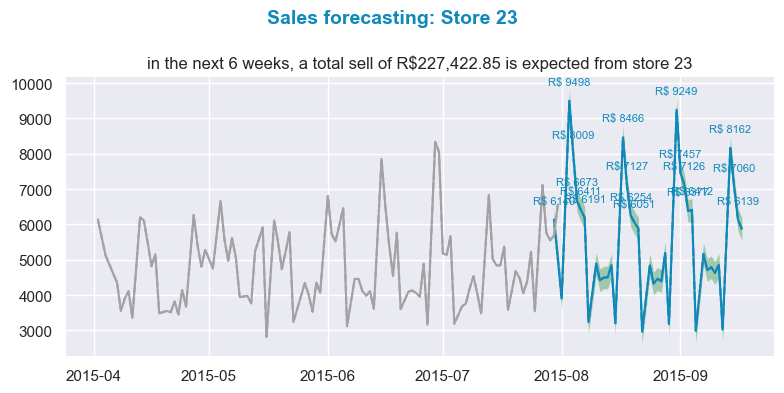

In [321]:
import matplotlib.pyplot as plt
cor = '#0f89b9'
#cor = '#B7280F' #rossmann red  #DD8B1B
#cor = '#253760'
cinza = "#787878"
fig, ax = plt.subplots(figsize=(8, 4))


# Título
fig.suptitle('Sales forecasting: Store {}'.format(store), fontsize=14, fontweight='bold', color=cor)
ax.set_title('in the next 6 weeks, a total sell of R${:,.2f} is expected from store {}'.format( d2.loc[i, 'prediction'],d2.loc[i, 'store'] ) )

## Gráfico Linha
candidato_line = ax.plot(d1['date'], d1['prediction'], label='line', color = cor)
# Margem de Erro 2 pontos percentuais
ax.fill_between(d1['date'], d1['prediction']-320, d1['prediction']+320, alpha=0.5, linewidth=0, color = 'g')
# Pontos
ax.plot(d1['date'], d1['prediction'], '--', color = cor)
for b in range(len(d1['prediction'])):
    if d1['prediction'].iloc[b] > 6000:
        ax.annotate('R$ {}'.format(round(d1['prediction'].iloc[b])),
                    xy = (d1['date'].iloc[b], d1['prediction'].iloc[b]),
                    xytext = (0, 10),
                    textcoords="offset points",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color=cor)
    if d1['prediction'].iloc[b] < 2800:
        ax.annotate('R$ {}'.format(round(d1['prediction'].iloc[b])),
                    xy = (d1['date'].iloc[b], d1['prediction'].iloc[b]),
                    xytext = (-0, -10),
                    textcoords="offset points",
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    color=cor)


## Gráfico Linha
candidato_line = ax.plot(df_raw['Date'], df_raw['Sales'], label='line', color = '#A2A1A3')
# Pontos
ax.plot(df_raw['Date'], df_raw['Sales'], '--', color = '#A2A1A3')



# Remover grids e eixos
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remover eixo y
#plt.gca().axes.get_yaxis().set_visible(False)

fig.tight_layout()
plt.show;

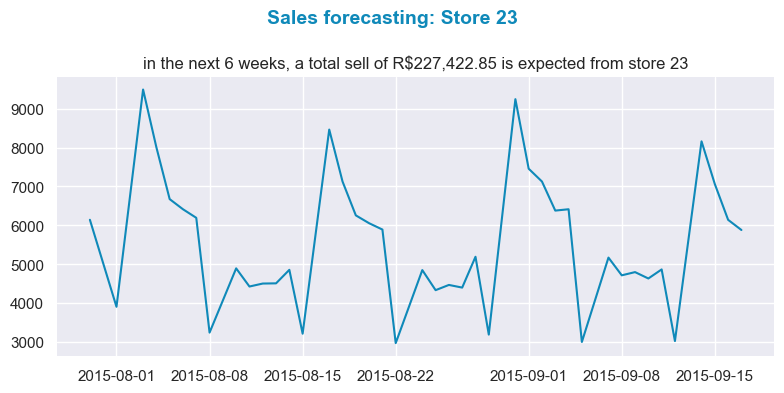

In [322]:
cor = '#0f89b9'
cinza = "#787878"
fig, ax = plt.subplots(figsize=(8, 4))


# Título
fig.suptitle('Sales forecasting: Store {}'.format(store), fontsize=14, fontweight='bold', color=cor)
ax.set_title('in the next 6 weeks, a total sell of R${:,.2f} is expected from store {}'.format( d2.loc[i, 'prediction'],d2.loc[i, 'store'] ) )

## Gráfico Linha
candidato_line = ax.plot(d1['date'], d1['prediction'], label='line', color = cor)

# Remover grids e eixos
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout()
plt.show;